In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
import os
from nltk.corpus import stopwords
from multiprocessing import Pool
from pymystem3 import Mystem
import tqdm

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 8.2 MB 10.0 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

--2022-04-28 13:28:42--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fnpq3z4bcnoktiv/positive.csv [following]
--2022-04-28 13:28:43--  https://www.dropbox.com/s/raw/fnpq3z4bcnoktiv/positive.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdd8f9533e0a2fec91677ef3267.dl.dropboxusercontent.com/cd/0/inline/BkSUxZzJrWzgqAJgMoOSd65i0G6qmsQLVBuRcSSgnuSWLrcR_LTZd39vr9ct-fRh4VWxQI95k76yfjORGwcmHqHpT26BP-0NHV1ceNsuaGmL446NI28rerZ69SNzFYViwxqql8NQEu7QKNvOwtq4nO9HVAhmoKyXJgYuLvSudtVtXg/file# [following]
--2022-04-28 13:28:43--  https://ucdd8f9533e0a2fec91677ef3267.dl.dropboxusercontent.com/cd/0/inline/BkSUxZzJrWzgqAJgMoOSd65i0G6qmsQLVBuRcSSgnuSWLrcR_LTZd39vr9ct-fRh4VWx

In [ ]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [ ]:
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
  tokens = regex.findall(text.lower())
  return [w for w in tokens if w.isalpha() and len(w) >= 3]

stopwords_list = stopwords.words('russian')

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
  lemmas = [lemmer.parse(w)[0].normal_form for w in words]
  return [w for w in lemmas if not w in stopwords and w.isalpha()]

def preprocess(text):
  return (lemmatize(find_words(text)))

In [ ]:
df.text.iloc[1]

'Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D'

In [ ]:
print(preprocess(df.text.iloc[1]))

['всё', 'таки', 'немного', 'похожий', 'мальчик', 'всё', 'равно', 'хороший']


In [ ]:
# random 10000 text from data
data = df.sample(10000)

In [ ]:
data['text']

68514     Сокриби родственникам погибшим в волгограде(((...
3058      RT @ollivercom: в ленте стало много Лермана. \...
87222     "Ты читала,что написано на двери?" - сказала М...
76159             Ужасно непривычно просыпаться без тебя ((
107034    @alsoldaty почему у меня нет таких смайликов? (((
                                ...                        
47964     RT @saponenkonanana: @mkiss_1 ну лично мне оно...
14902     RT @tatihonova: @hope762 А что делает Президен...
53993     Красачик)) — Круасанчик блядь http://t.co/OHel...
112503    нет, я смеялся над этим чудовищем! Не до песен...
53943     @Pavsekakii Согласна. Такого унижения детей я ...
Name: text, Length: 10000, dtype: object

In [ ]:
map(preprocess, df['text'])

In [ ]:
preprocessed_text = list(map(preprocess, data['text']))

In [ ]:
data['text'] = preprocessed_text
data.sample(3)

,text,label
29716,"[завтра, фотографироваться, чёрт, мочь, придум...",negative
4222,"[kantiha, ретвитя, катя, хотеть, читатель, дел...",positive
90557,"[твит, мафия, начать, отписываться]",negative


In [ ]:
# Model LDA

In [ ]:
!pip install -U gensim

     |████████████████████████████████| 24.1 MB 1.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
from gensim.models import *
from gensim import corpora

In [ ]:
dictionary = corpora.Dictionary(data['text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None)
dictionary.save('tweet.dict')

In [ ]:
# Векторизуем документы

In [ ]:
corpus = [dictionary.doc2bow(text) for text in data['text']]
corpora.MmCorpus.serialize('tweet.model', corpus)

In [ ]:
# Обучение модели

In [ ]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

CPU times: user 3.37 s, sys: 16.7 ms, total: 3.38 s
Wall time: 3.4 s


In [ ]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(8,
  '0.852*"хотеть" + 0.042*"туда" + 0.038*"сторона" + 0.000*"ещё" + 0.000*"понять" + 0.000*"хороший" + 0.000*"мочь" + 0.000*"скучать" + 0.000*"дело" + 0.000*"говорить"'),
 (12,
  '0.200*"вернуться" + 0.187*"милый" + 0.123*"ужасно" + 0.105*"просыпаться" + 0.000*"сегодня" + 0.000*"право" + 0.000*"болеть" + 0.000*"голова" + 0.000*"чувствовать" + 0.000*"целый"'),
 (5,
  '0.303*"неделя" + 0.199*"смочь" + 0.161*"телефон" + 0.159*"твит" + 0.039*"любой" + 0.002*"сесть" + 0.000*"последний" + 0.000*"ещё" + 0.000*"ставить" + 0.000*"жизнь"'),
 (19,
  '0.743*"день" + 0.105*"пока" + 0.043*"мало" + 0.027*"капец" + 0.000*"рождение" + 0.000*"сегодня" + 0.000*"весь" + 0.000*"каждый" + 0.000*"ещё" + 0.000*"последний"'),
 (14,
  '0.823*"почему" + 0.000*"большой" + 0.000*"вариант" + 0.000*"человек" + 0.000*"знать" + 0.000*"весь" + 0.000*"видеть" + 0.000*"жопа" + 0.000*"лето" + 0.000*"полный"'),
 (18,
  '0.346*"завтра" + 0.281*"делать" + 0.184*"спать" + 0.096*"работа" + 0.029*"быстро" + 0.005*"волгоград

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=46ed800993b57804e8aa41ccdf656605046636b0e50ca01b042cf803a62f3851
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


CPU times: user 835 ms, sys: 64.3 ms, total: 899 ms
Wall time: 3.22 s


In [ ]:
print(lda.log_perplexity(corpus))

-24.255440180757123


In [ ]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Персплексия:  2.924126582333598e-11


In [ ]:
coherence_model_lda = CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.44977113999453844


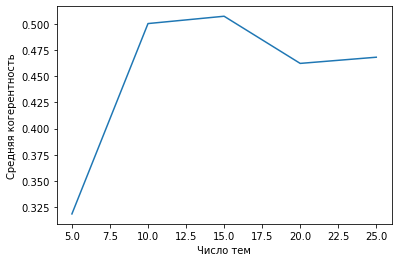

In [ ]:
topics_list = [5, 10, 15, 20, 25]
coherences = []

for num in topics_list:
  lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
  coherences.append(CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

In [ ]:
lda_15 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=15, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_15, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
